In [124]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import joblib
import os
from scipy.spatial import distance



# Load in the data 

In [91]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


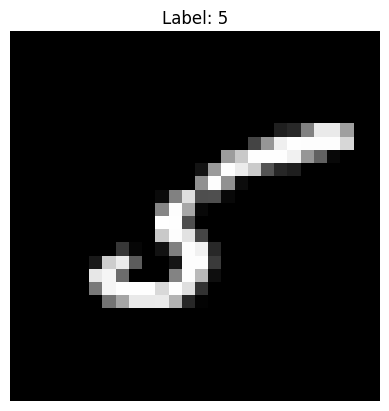

In [92]:

# Reshape the data to a 28x28 image
image_index = 11  # You can change this index to display different images
image = X.iloc[image_index].to_numpy().reshape(28, 28)
# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {y[image_index]}')
plt.axis('off')  # Hide the axes
plt.show()


In [93]:
X = X.values.reshape(-1, 28, 28)  # Make sure X is reshaped into 28x28 images


In [94]:
# Define the function to extract 5x5 patches
def extract_patches(images, patch_size=5):
    patches = []
    for image in images:
        for i in range(image.shape[0] - patch_size + 1):
            for j in range(image.shape[1] - patch_size + 1):
                patch = image[i:i + patch_size, j:j + patch_size]
                if np.sum(patch) > 0:  # Filter out all-zero patches
                    patches.append(patch.flatten())
    return np.array(patches)



In [95]:
# Sample 10% of the images
X_sample = X[np.random.choice(len(X), size = int(len(X) * 0.1), replace =False)]

In [96]:

# Extract patches
patches = extract_patches(X_sample)

# Check what the patches look like 

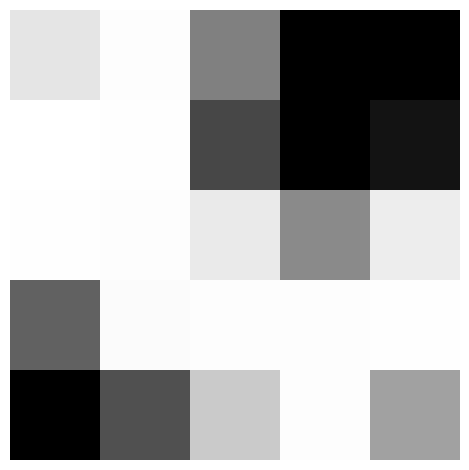

In [97]:
i = 7000

fig, ax = plt.subplots()
patch = patches[i].reshape(5,5)
ax.imshow(patch, cmap ='gray', interpolation = 'nearest')
ax.axis('off')
plt.tight_layout()
plt.show()

### Save patches  

In [98]:
np.save('mnist_patches.npy', patches)

In [99]:
patches = np.load('mnist_patches.npy')
norms = np.linalg.norm(patches, axis = 1, keepdims= True) #compute the norm 
patches = patches / norms #normalize the patches 


In [100]:
def save_models(models, directory='models'):
    import os
    if not os.path.exists(directory):
        os.makedirs(directory)
    for k, model in models.items():
        filename = os.path.join(directory, f'kmeans_{k}.pkl')
        joblib.dump(model, filename)

In [101]:
def perform_kmeans_clustering(data, k_values, batch_size=6, max_iter=10, n_init="auto", verbose=True):
    models = {}
    for k in k_values:
        if verbose:
            print(f"Clustering with k = {k}...")
        try:
            kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=batch_size, max_iter=max_iter, n_init=n_init)
            kmeans.fit(data)
            models[k] = kmeans
            if verbose:
                print(f"Done clustering with k = {k}.")
        except Exception as e:
            if verbose:
                print(f"Failed to cluster with k = {k} due to {e}")
    return models




In [102]:

# Usage example
k_values = [100, 500, 1000, 2000, 3000, 4000, 5000, 10000]
models = perform_kmeans_clustering(patches, k_values)

save_models(models)


Clustering with k = 100...
Done clustering with k = 100.
Clustering with k = 500...
Done clustering with k = 500.
Clustering with k = 1000...
Done clustering with k = 1000.
Clustering with k = 2000...
Done clustering with k = 2000.
Clustering with k = 3000...
Done clustering with k = 3000.
Clustering with k = 4000...
Done clustering with k = 4000.
Clustering with k = 5000...
Done clustering with k = 5000.
Clustering with k = 10000...
Done clustering with k = 10000.


In [103]:
models

{100: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=100, n_init='auto',
                 random_state=42),
 500: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=500, n_init='auto',
                 random_state=42),
 1000: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=1000, n_init='auto',
                 random_state=42),
 2000: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=2000, n_init='auto',
                 random_state=42),
 3000: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=3000, n_init='auto',
                 random_state=42),
 4000: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=4000, n_init='auto',
                 random_state=42),
 5000: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=5000, n_init='auto',
                 random_state=42),
 10000: MiniBatchKMeans(batch_size=6, max_iter=10, n_clusters=10000, n_init='auto',
                 random_state=42)}

In [104]:
def load_models(directory='models', k_values=None):
    """Load k-means models from specified directory based on provided k values."""
    models = {}
    if k_values is None:
        # If no specific k_values provided, try to load all models in the directory
        model_files = [f for f in os.listdir(directory) if f.startswith('kmeans_') and f.endswith('.pkl')]
        k_values = [int(f.split('_')[1].split('.')[0]) for f in model_files]

    for k in k_values:
        filename = os.path.join(directory, f'kmeans_{k}.pkl')
        try:
            models[k] = joblib.load(filename)
            print(f"Loaded model for k={k} successfully.")
        except FileNotFoundError:
            print(f"No model found for k={k} in {directory}.")
        except Exception as e:
            print(f"Error loading model for k={k}: {e}")

    return models

# Example usage
k_values = [100, 500, 1000, 5000, 10000]  # Define k values for which models were saved
models = load_models(directory='models', k_values=k_values)


Loaded model for k=100 successfully.
Loaded model for k=500 successfully.
Loaded model for k=1000 successfully.
Loaded model for k=5000 successfully.
Loaded model for k=10000 successfully.


In [105]:
def sample_and_plot_centroids(models, data, k_values, num_centroids=5, patches_per_centroid=10, random_seed=42):
    np.random.seed(random_seed)
    
    for k in k_values:
        kmeans = models[k]
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        sampled_indices = np.random.choice(len(centroids), size=num_centroids, replace=False)
        
        # Create a figure for each k value
        for i, idx in enumerate(sampled_indices):
            centroid = centroids[idx].reshape(5, 5)
            
            # Create a figure with two rows: one for the centroid, one for patches
            fig, axes = plt.subplots(2, patches_per_centroid, figsize=(12, 4))
            fig.suptitle(f'Centroid {idx} for k={k}', fontsize=16)

            # Display the centroid in the first row, spanning all columns
            for ax in axes[0, :]:  # Hide all subplot axes in the first row except for the first one
                ax.axis('off')
            ax_centroid = axes[0, (patches_per_centroid//2)]  # Display centroid in the middle of the row
            ax_centroid.imshow(centroid, cmap='gray', interpolation='nearest')
            ax_centroid.set_title('Centroid')
            ax_centroid.axis('off')  # Optionally, show axis

            # Randomly select 10 patches assigned to this centroid
            assigned_patches_indices = np.where(labels == idx)[0]
            if len(assigned_patches_indices) > patches_per_centroid:
                sampled_patch_indices = np.random.choice(assigned_patches_indices, size=patches_per_centroid, replace=False)
            else:
                sampled_patch_indices = assigned_patches_indices

            # Display each patch in the second row
            for j, patch_idx in enumerate(sampled_patch_indices):
                patch_image = data[patch_idx].reshape(5, 5)
                axes[1, j].imshow(patch_image, cmap='gray', interpolation='nearest')
                axes[1, j].axis('off')  # Optionally, show axis
                axes[1, j].set_title(f'Patch {j+1}')

            plt.tight_layout()
            plt.show()


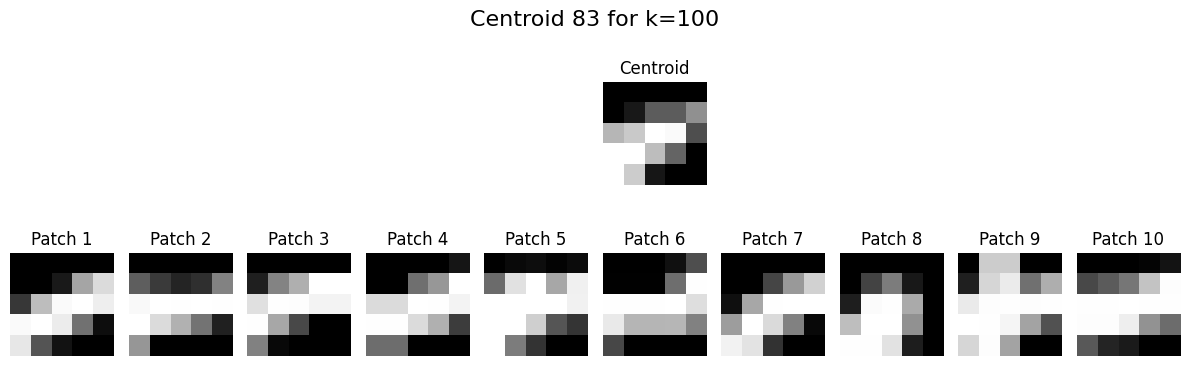

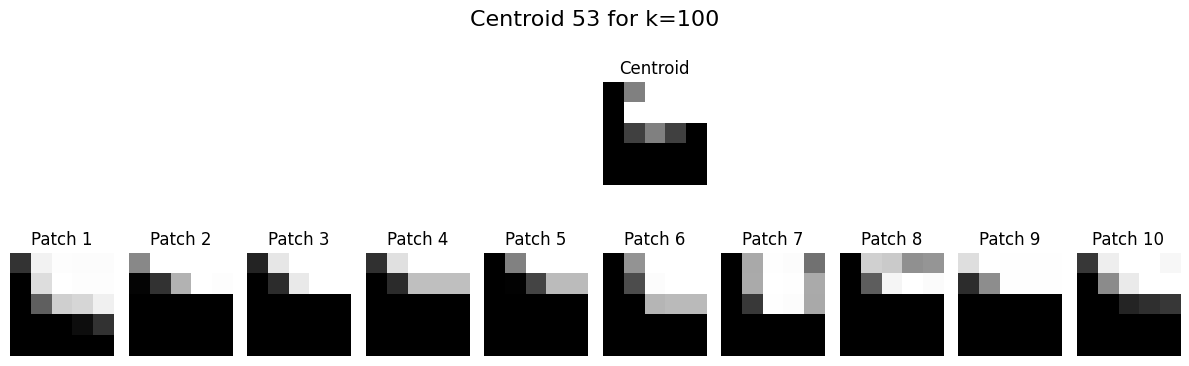

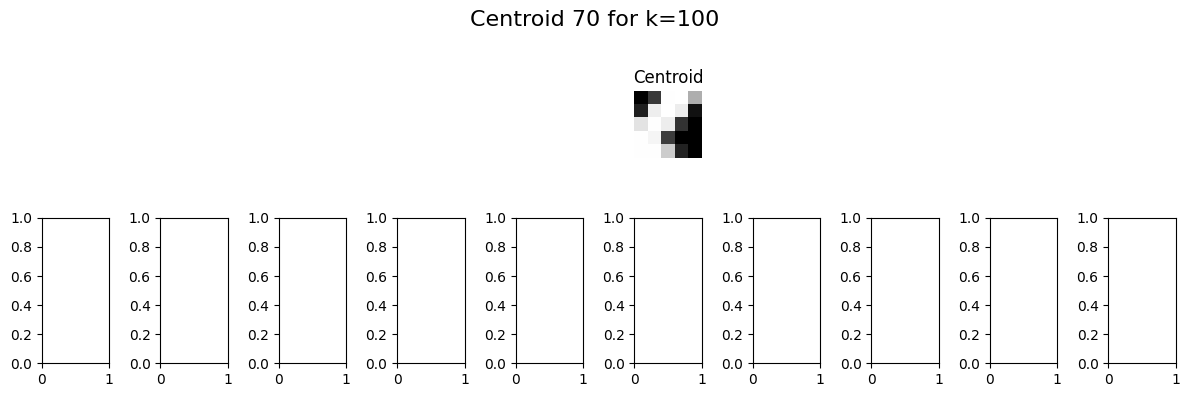

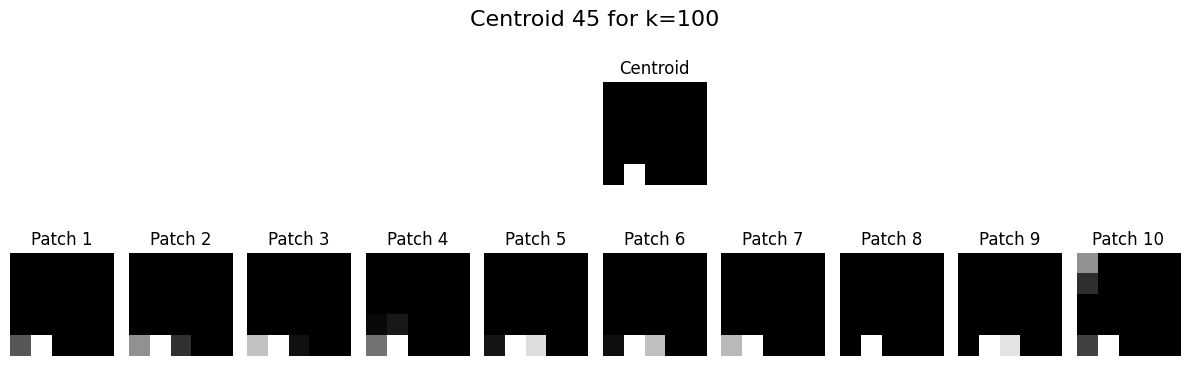

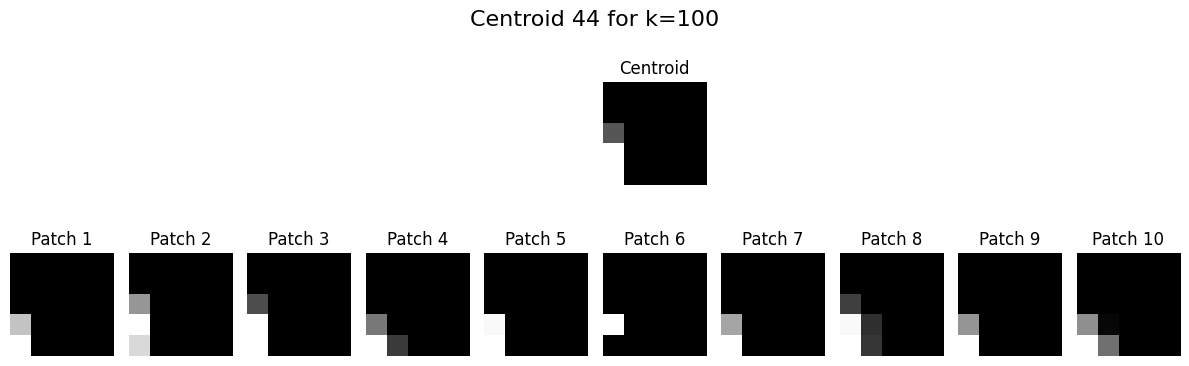

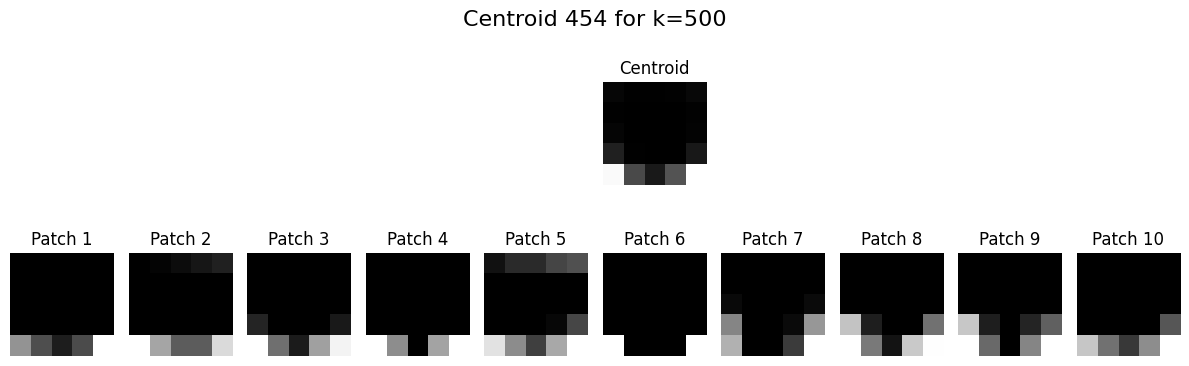

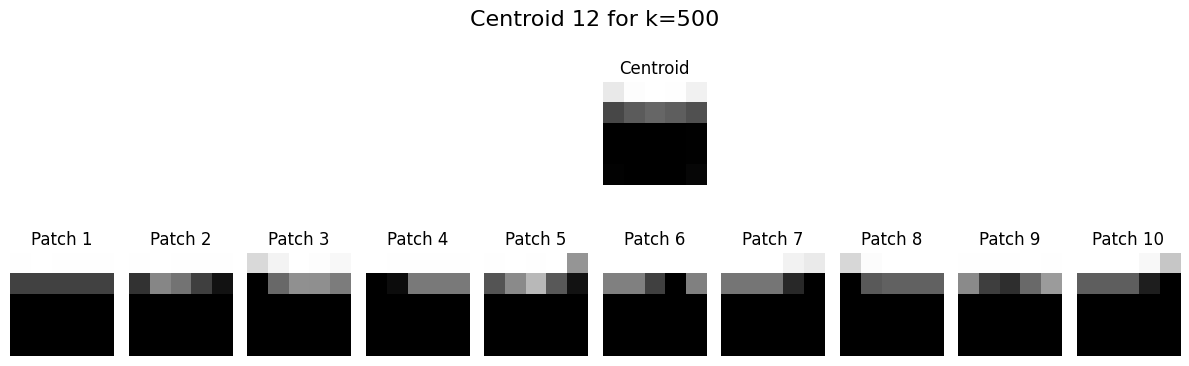

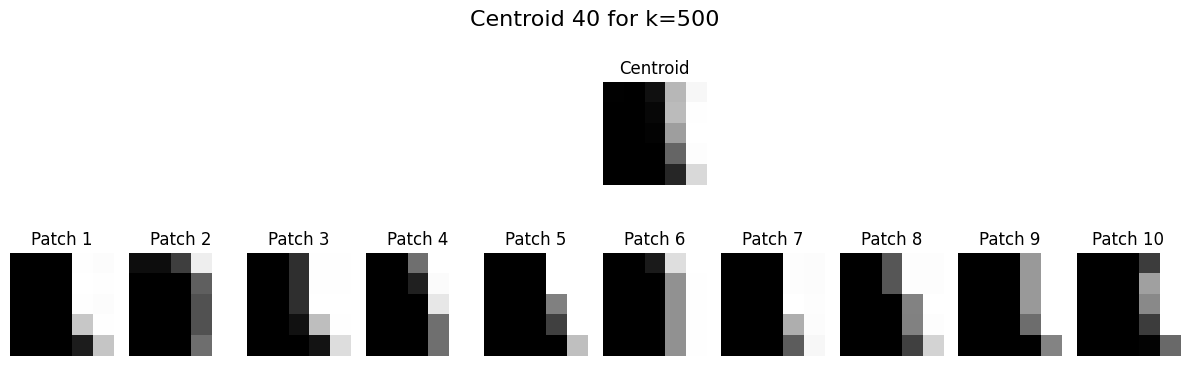

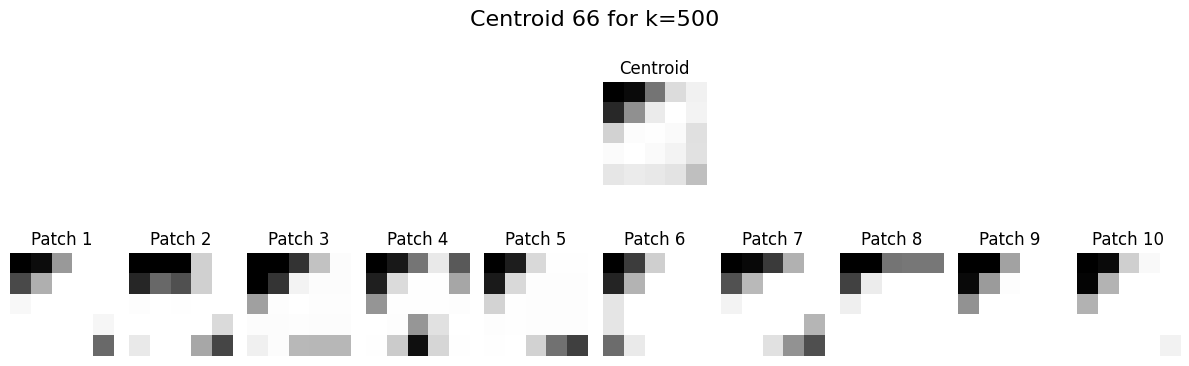

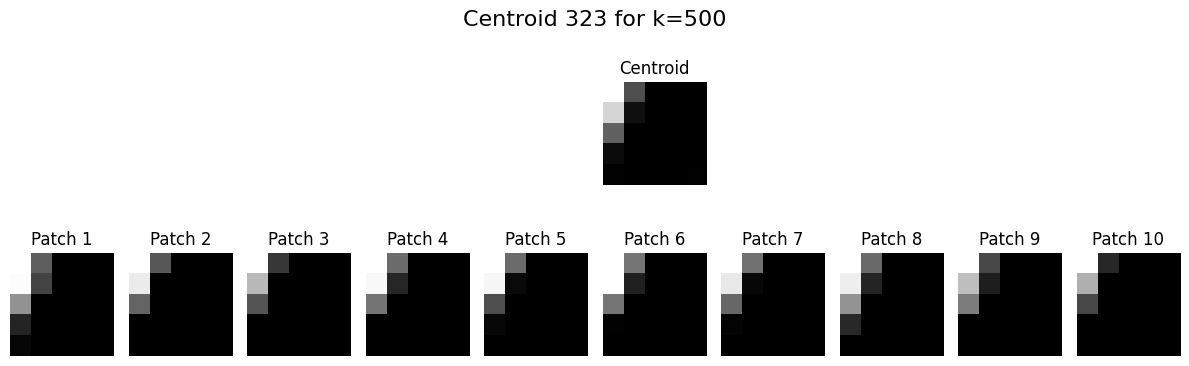

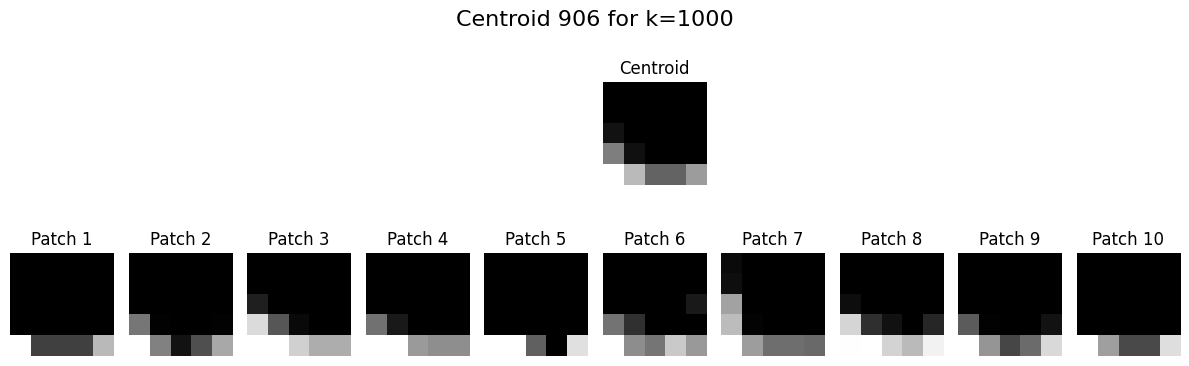

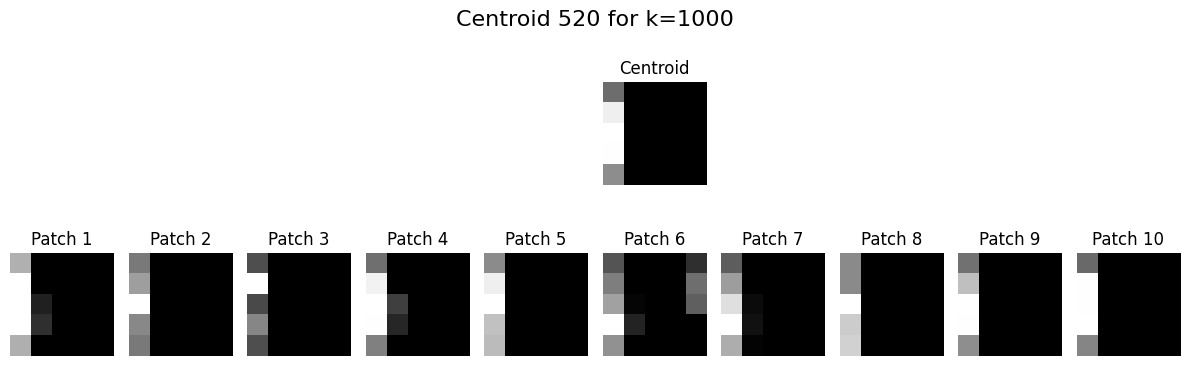

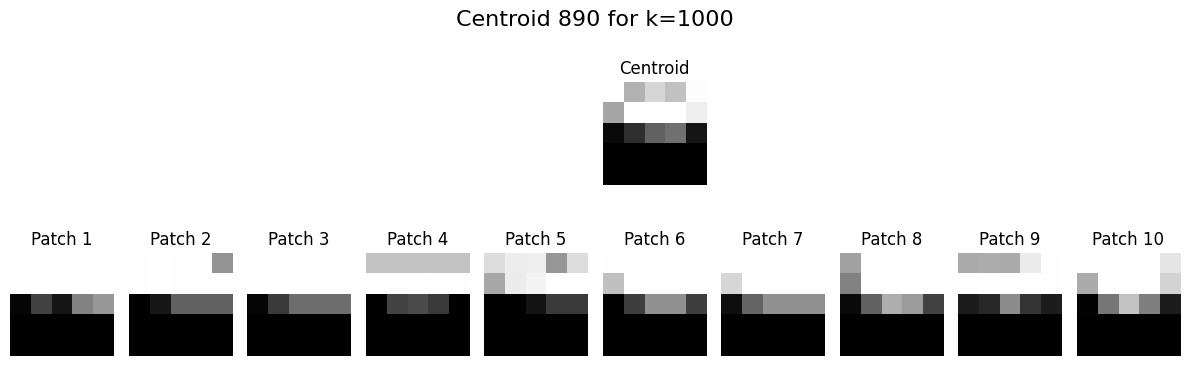

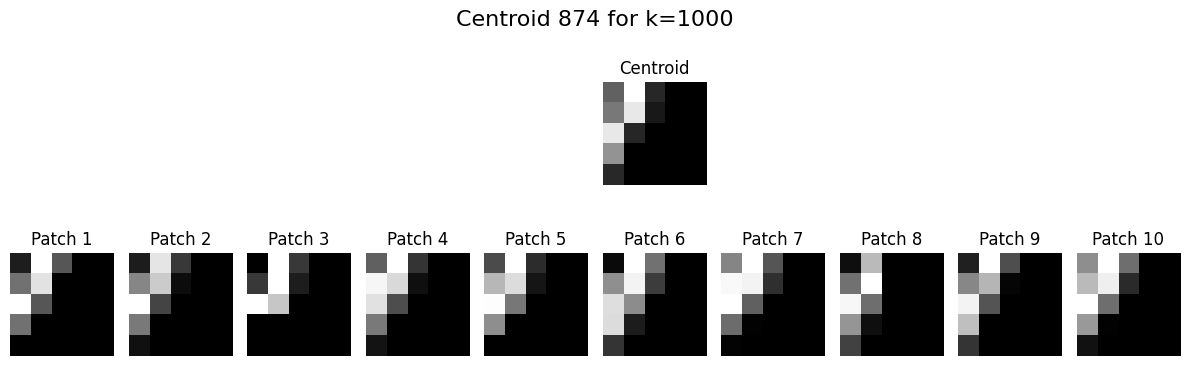

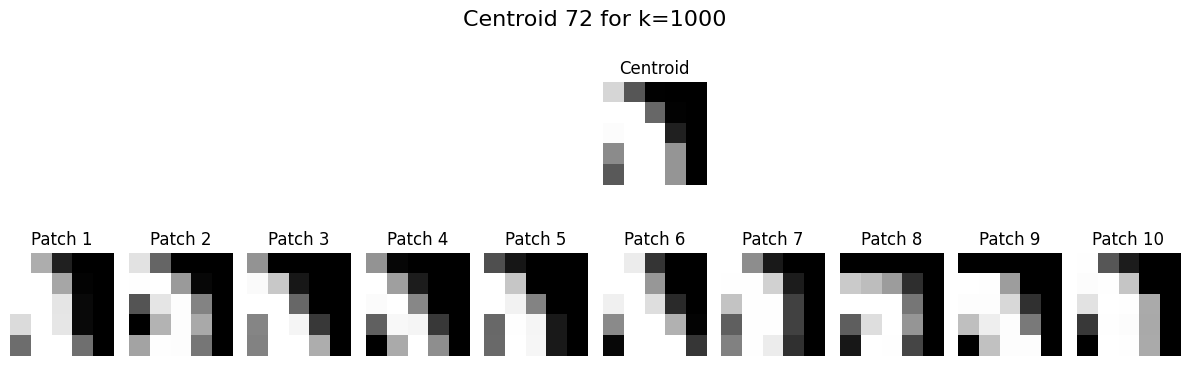

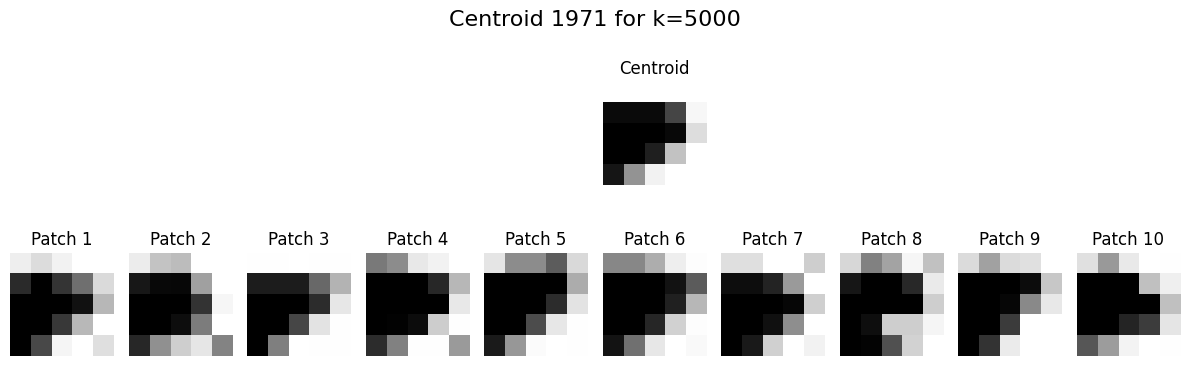

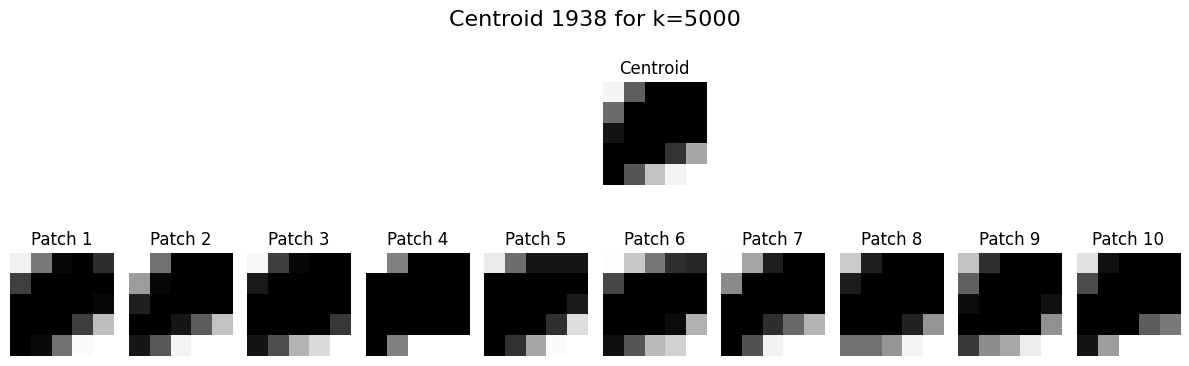

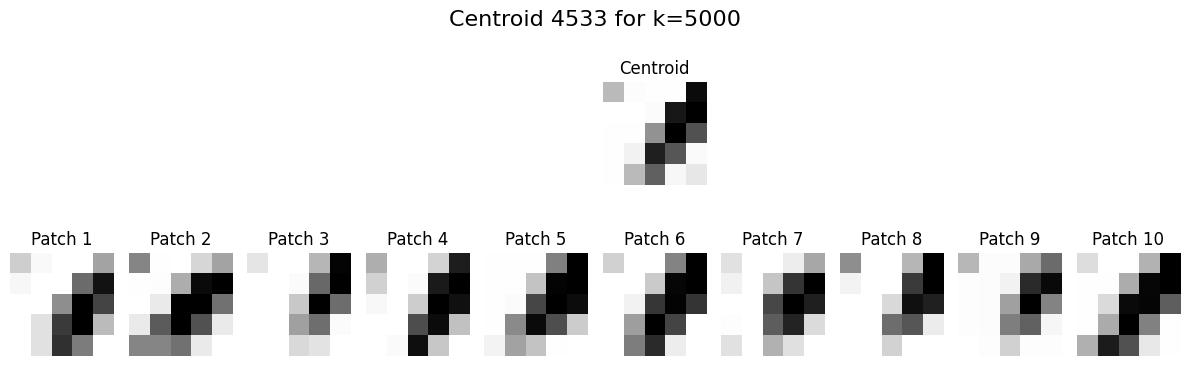

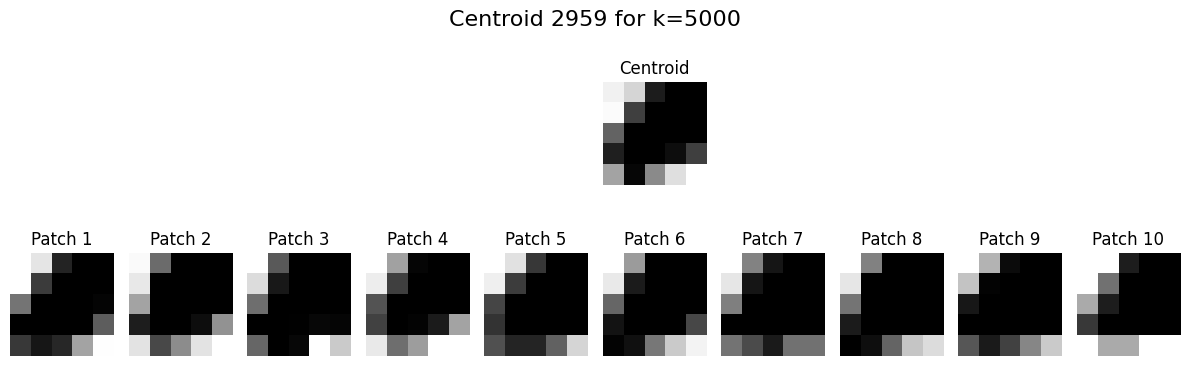

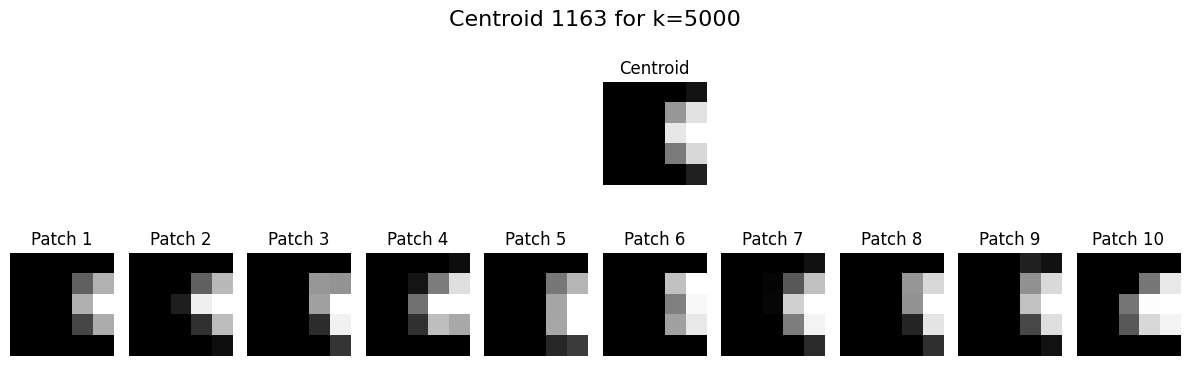

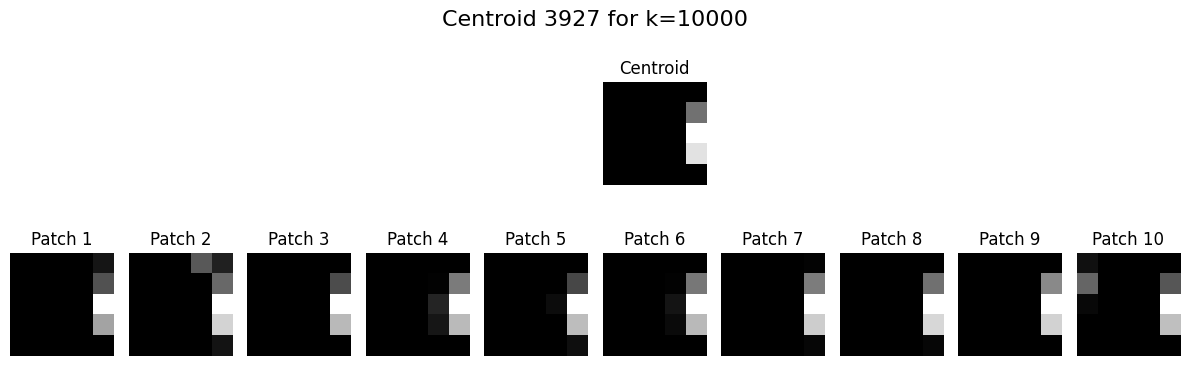

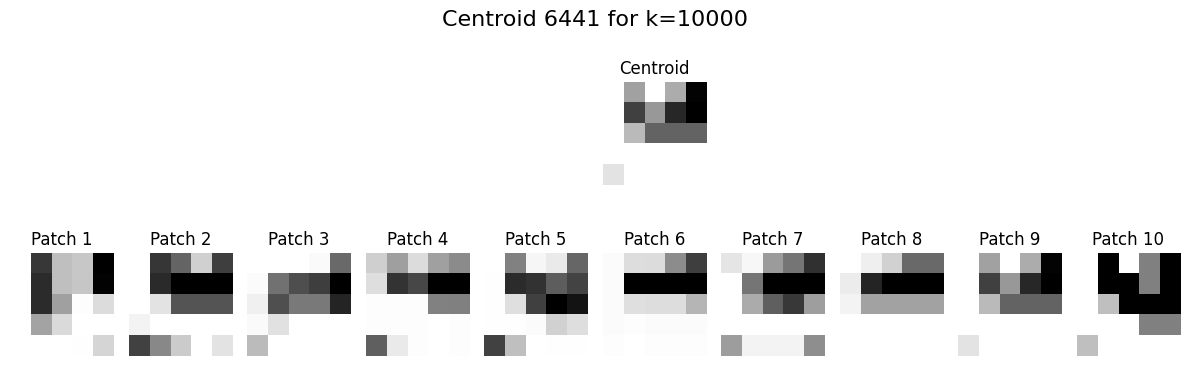

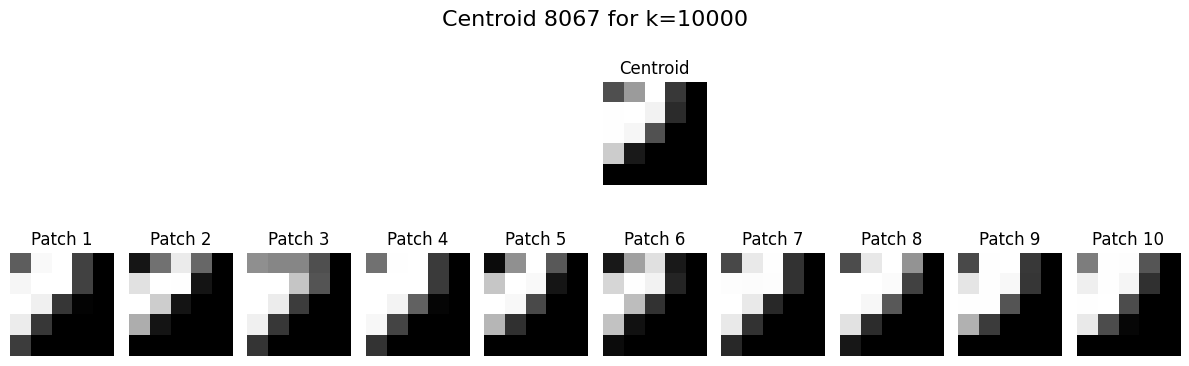

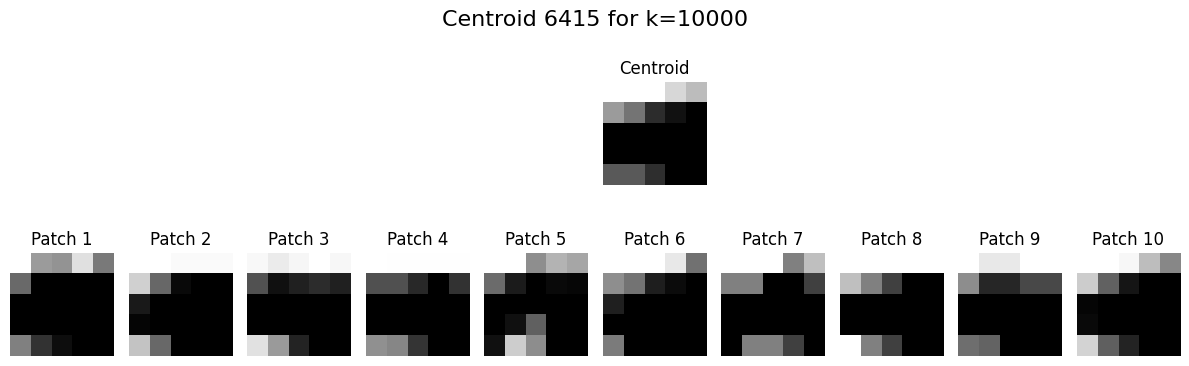

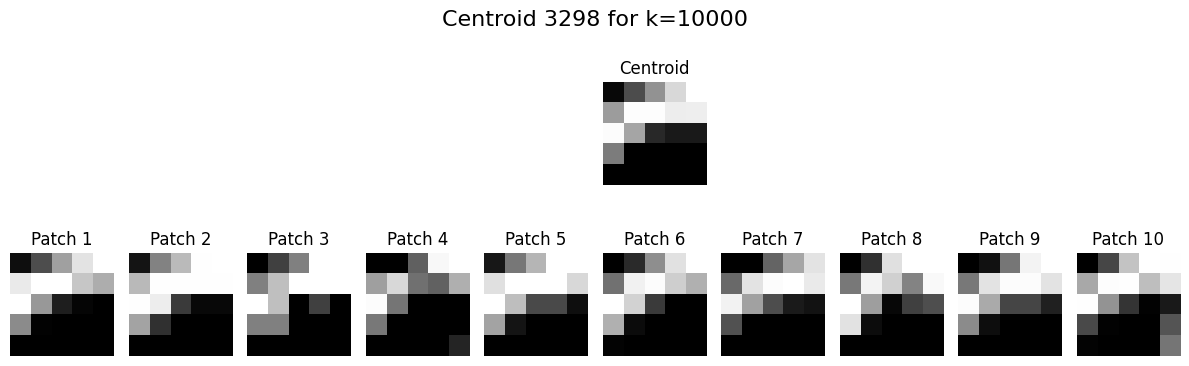

In [106]:
sample_and_plot_centroids(models, patches, k_values)


Essentially what the below code does it it measures the distances between centroids and then saves them since it can be computationally intensive to compute all the distances. Once we have done this we use a function to state an index and then see the clusters around that index 

In [122]:


def plot_centroid_and_neighbors(models, k, centroid_index, n_neighbors=5):
    centroids = models[k].cluster_centers_
    # Compute pairwise distances
    dist_array = distance.pdist(centroids, 'euclidean')
    distances = distance.squareform(dist_array)

    # Find nearest neighbors
    nearest_indices = find_nearest_centroids(distances, centroid_index, n_neighbors)
    
    # Determine layout
    rows = (n_neighbors + 1) // 5 + 1  # Assuming max 5 columns for better visibility
    cols = min(n_neighbors + 1, 5)  # Max 5 columns

    # Adjust figure size dynamically based on the number of neighbors
    fig_width = 4 * cols
    fig_height = 4 * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    
    # Flatten axes array for easy indexing
    axes = axes.flatten()
    
    # Plot the chosen centroid
    axes[0].imshow(centroids[centroid_index].reshape(5, 5), cmap='gray')
    axes[0].set_title(f'Centroid {centroid_index}')
    axes[0].axis('off')

    # Plot nearest neighbors
    for i, idx in enumerate(nearest_indices, start=1):
        axes[i].imshow(centroids[idx].reshape(5, 5), cmap='gray')
        axes[i].set_title(f'Centroid {idx}')
        axes[i].axis('off')

    # Turn off unused axes
    for j in range(n_neighbors + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Centroid {centroid_index} and Its Nearest Neighbors', fontsize=16)
    plt.tight_layout()
    plt.show()

def find_nearest_centroids(distances, centroid_index, n_neighbors=5):
    """Find the indices of the nearest neighbors to a given centroid."""
    centroid_distances = distances[centroid_index]
    nearest_indices = np.argsort(centroid_distances)[1:n_neighbors + 1]  # Exclude the centroid itself
    return nearest_indices


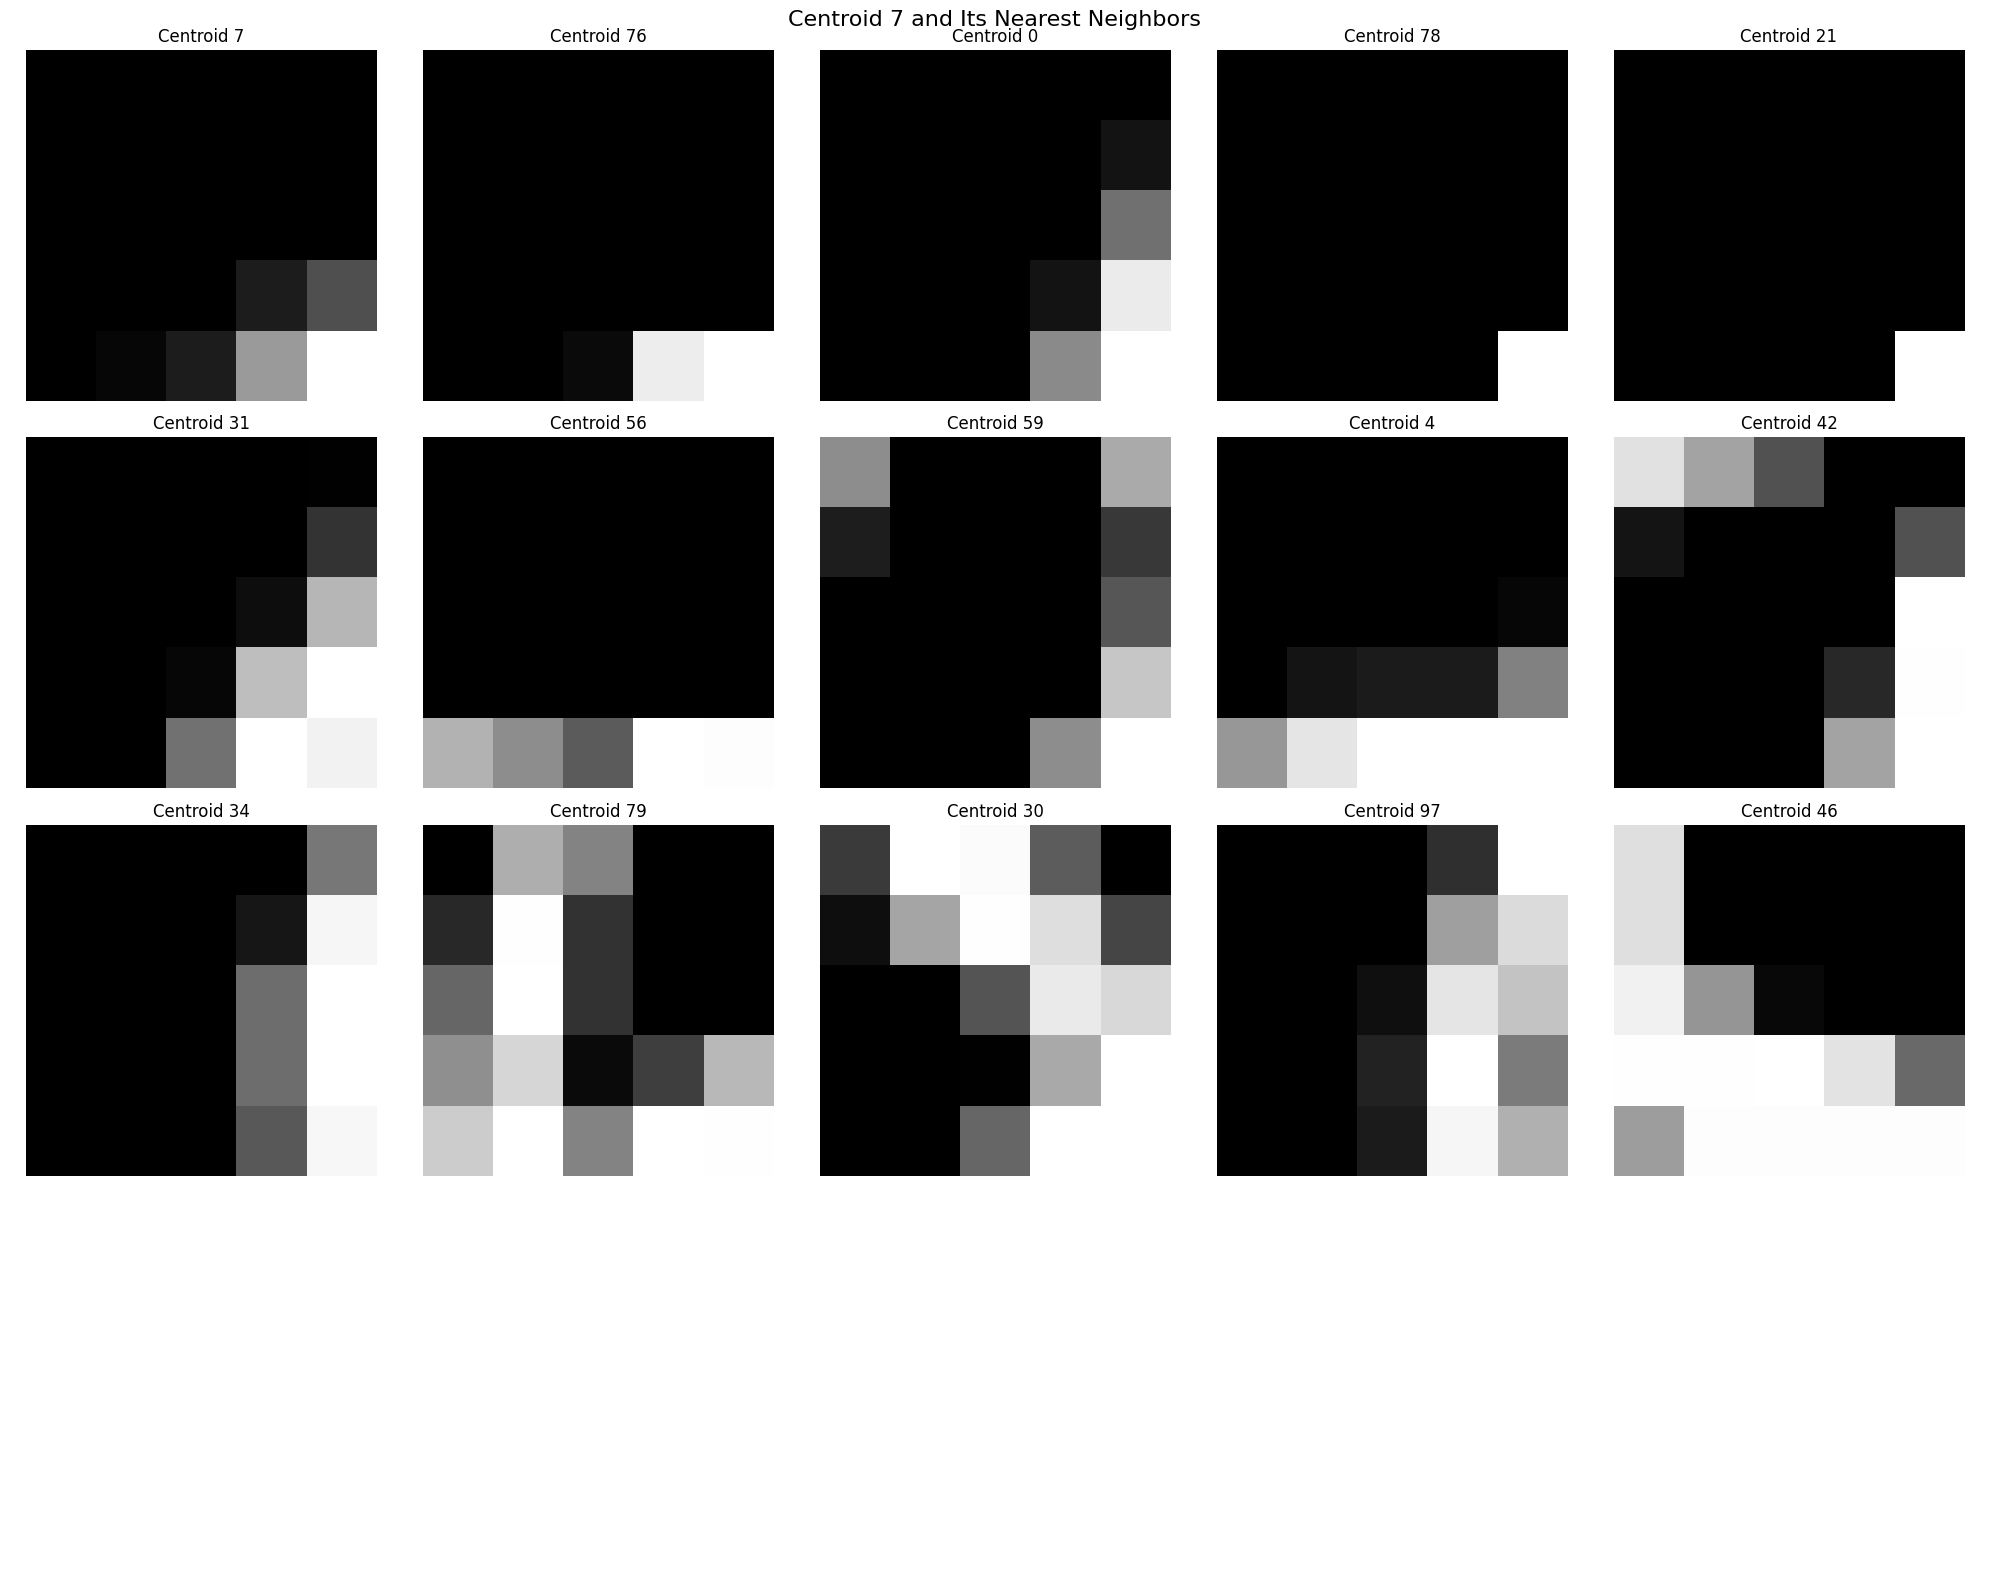

In [123]:

# Example usage
k = 100  # Specify the value of d
centroid = 7
plot_centroid_and_neighbors(models, k, centroid, n_neighbors=14)


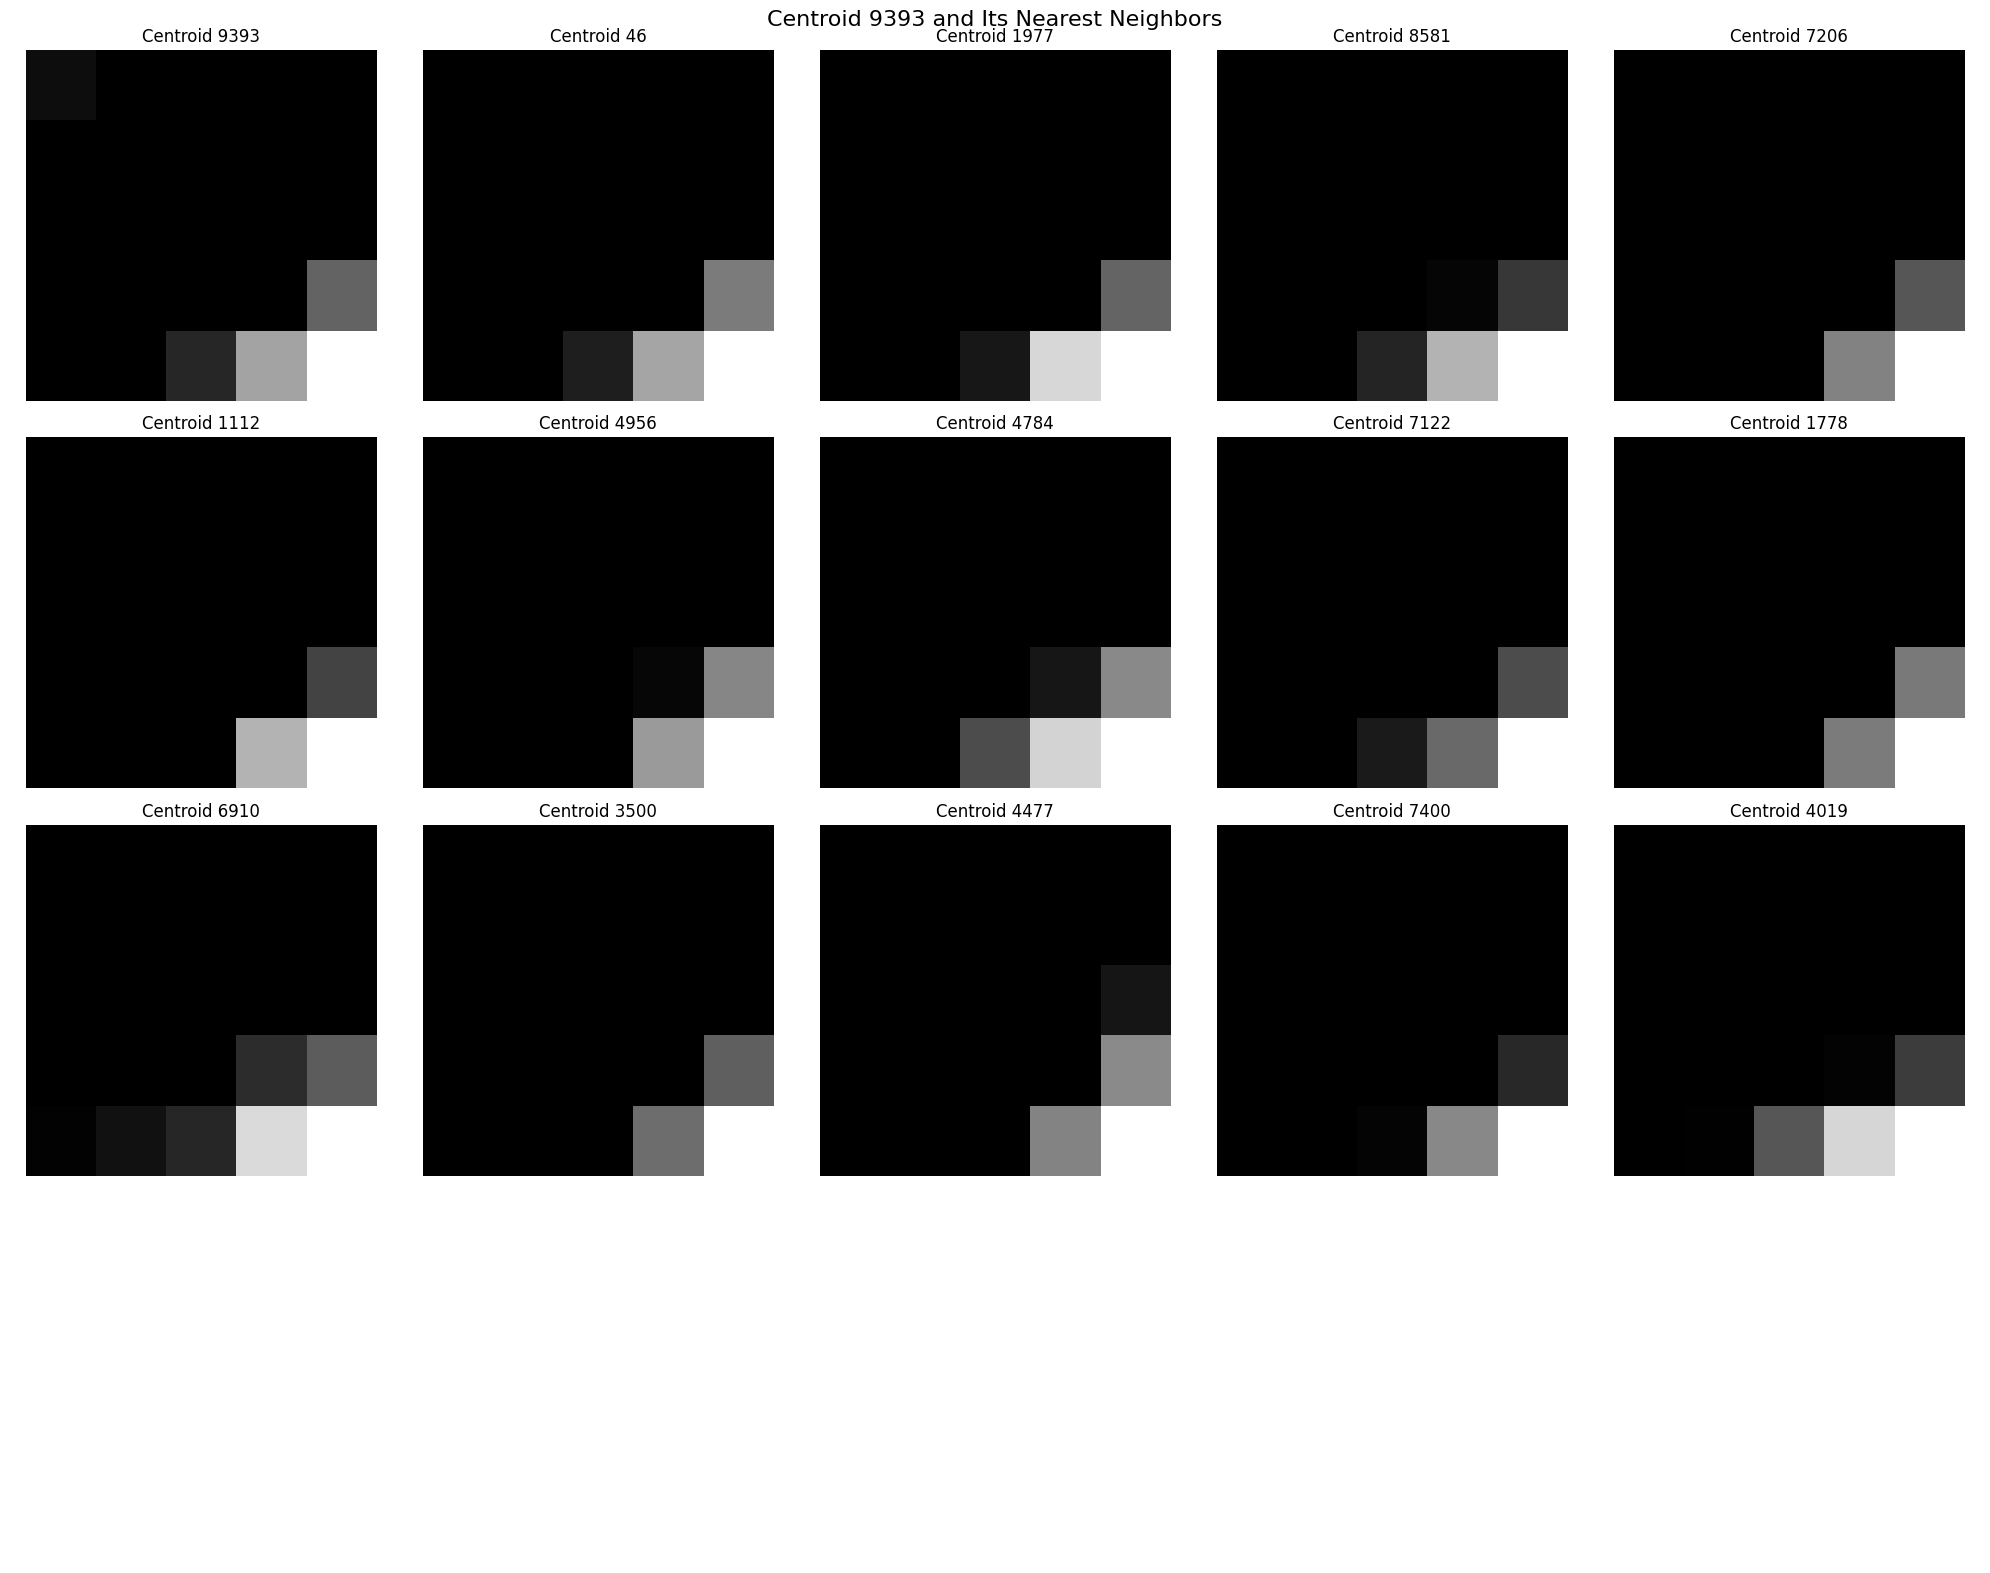

In [120]:

# Example usage
k = 10000  # Specify the value of d
centroid = 9393
plot_centroid_and_neighbors(models, k, centroid, n_neighbors=14)

In [55]:
def compare_centroids_across_k(models, k1, k2, centroid_index_k1):
    """
    Compare a centroid from k1 with centroids in k2 and find the closest centroid.

    Args:
    - models: Dictionary containing the MiniBatchKMeans models for various k values.
    - k1: The first k value and the source of the single centroid.
    - k2: The second k value for comparing all centroids against the k1 centroid.
    - centroid_index_k1: Index of the centroid in k1 to compare against all centroids in k2.
    """
    # Extract the specific centroid from k1
    centroid_k1 = models[k1].cluster_centers_[centroid_index_k1]

    # Get all centroids from k2
    centroids_k2 = models[k2].cluster_centers_

    # Compute the distances between centroid_k1 and all centroids in k2
    dists = distance.cdist([centroid_k1], centroids_k2, 'euclidean')[0]
    
    # Find the index of the closest centroid in k2
    closest_index_k2 = np.argmin(dists)
    closest_centroid_k2 = centroids_k2[closest_index_k2]
    closest_distance = dists[closest_index_k2]

    # Plot both centroids for visual comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(centroid_k1.reshape(5, 5), cmap='gray')
    ax[0].set_title(f'Centroid {centroid_index_k1} from k={k1}')
    ax[0].axis('off')

    ax[1].imshow(closest_centroid_k2.reshape(5, 5), cmap='gray')
    ax[1].set_title(f'Closest Centroid from k={k2} (Index {closest_index_k2})')
    ax[1].axis('off')

    plt.suptitle(f'Comparison of Centroids: Closest to k1={k1} Centroid in k2={k2}\nDistance: {closest_distance:.2f}')
    plt.show()

    return closest_index_k2, closest_distance


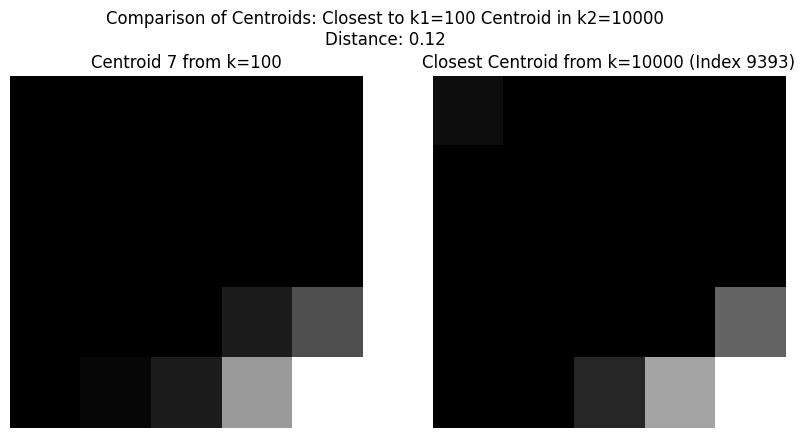

In [119]:

# Example usage, assuming models have been trained for k=100 and k=10000
k1 = 100
k2 = 10000
centroid_index_k1 = 7  # Eample index, choose based on your specific needs
closest_index_k2, closest_distance = compare_centroids_across_k(models, k1, k2, centroid_index_k1)


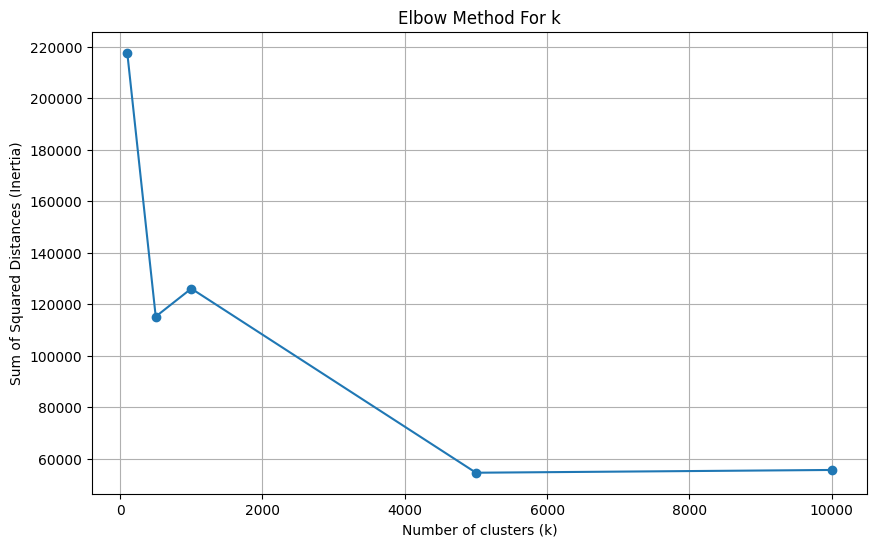

In [89]:

def elbow_plot_from_models(models):
    inertias = []
    k_values = sorted(models.keys())

    for k in k_values:
        kmeans = models[k]
        inertias.append(kmeans.inertia_)  # Using the inertia attribute directly from pre-trained models

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of Squared Distances (Inertia)')
    plt.title('Elbow Method For k')
    plt.grid(True)
    plt.show()

# Example usage
elbow_plot_from_models(models)
